In [1]:
import numpy as np
import sys
print(sys.version)
from pomegranate import *
import pandas as pd

import missingno as msno

import seaborn as sns
sns.set_style("white")
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [2]:
data = pd.read_csv('Data/data_rms_bearing_1.txt', header = None, sep='\s+')

# remove column 8
data = data.drop([8], axis=1)
data.head()

,0,1,2,3,4,5,6,7
0,0.124086,0.123077,0.124692,0.123098,0.121993,0.120885,0.120650,0.122520
1,0.125157,0.121047,0.119458,0.121360,0.123017,0.120512,0.123048,0.122855
2,0.125133,0.125864,0.122109,0.126549,0.124533,0.121847,0.120396,0.123333
3,0.125903,0.122256,0.125582,0.123162,0.122565,0.122018,0.124485,0.125027
4,0.123719,0.128365,0.121615,0.123504,0.119830,0.126062,0.123403,0.122291


# Details Dataset
- Recording Duration:  October 22, 2003 12:06:24 to November 25, 2003 23:39:56 
- No. of Files: 2,156 
- No. of Channels:  8  
- Channel Arrangement:  Bearing 1 – Ch 1&2; Bearing 2 – Ch 3&4;   Bearing 3 – Ch 5&6; Bearing 4 – Ch 7&8. 
- File Recording Interval:  Every 10 minutes (except the first 43 files were taken every 5 minutes) 
- File Format:  ASCII 
- Description: At the end of the test-to-failure experiment, inner race defect occurred in bearing 3 and roller element defect in bearing 4. 

In [3]:
# create list minutes
minutes = []
start = 0
for t in range(len(data)):
    # Every 10 minutes (except the first 43 files were taken every 5 minutes) 
    minutes.append(start)
    if t <= 43: 
        start += 5
    else:
        start += 20

In [4]:
# add into dataframe
se = pd.Series(minutes)
data['Time'] = se.values
data.head()

,0,1,2,3,4,5,6,7,Time
0,0.124086,0.123077,0.124692,0.123098,0.121993,0.120885,0.120650,0.122520,0
1,0.125157,0.121047,0.119458,0.121360,0.123017,0.120512,0.123048,0.122855,5
2,0.125133,0.125864,0.122109,0.126549,0.124533,0.121847,0.120396,0.123333,10
3,0.125903,0.122256,0.125582,0.123162,0.122565,0.122018,0.124485,0.125027,15
4,0.123719,0.128365,0.121615,0.123504,0.119830,0.126062,0.123403,0.122291,20


In [5]:
data.describe()

,0,1,2,3,4,5,6,7,Time
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.152867,0.153102,0.151212,0.150680,0.153969,0.150338,0.150380,0.150312,20896.887755
std,0.012501,0.012814,0.013307,0.012899,0.013333,0.013063,0.012918,0.012780,12438.905491
min,0.119746,0.117820,0.116974,0.115786,0.119502,0.116332,0.116370,0.117361,0.000000
25%,0.149213,0.149268,0.147060,0.146744,0.150438,0.146495,0.146565,0.146482,10115.000000
50%,0.151007,0.151351,0.149639,0.148874,0.152409,0.148438,0.148448,0.148342,20890.000000
75%,0.156103,0.156384,0.154420,0.154026,0.158056,0.153872,0.153553,0.153606,31665.000000
max,0.326161,0.325306,0.377078,0.349152,0.322789,0.347876,0.358188,0.320975,42440.000000


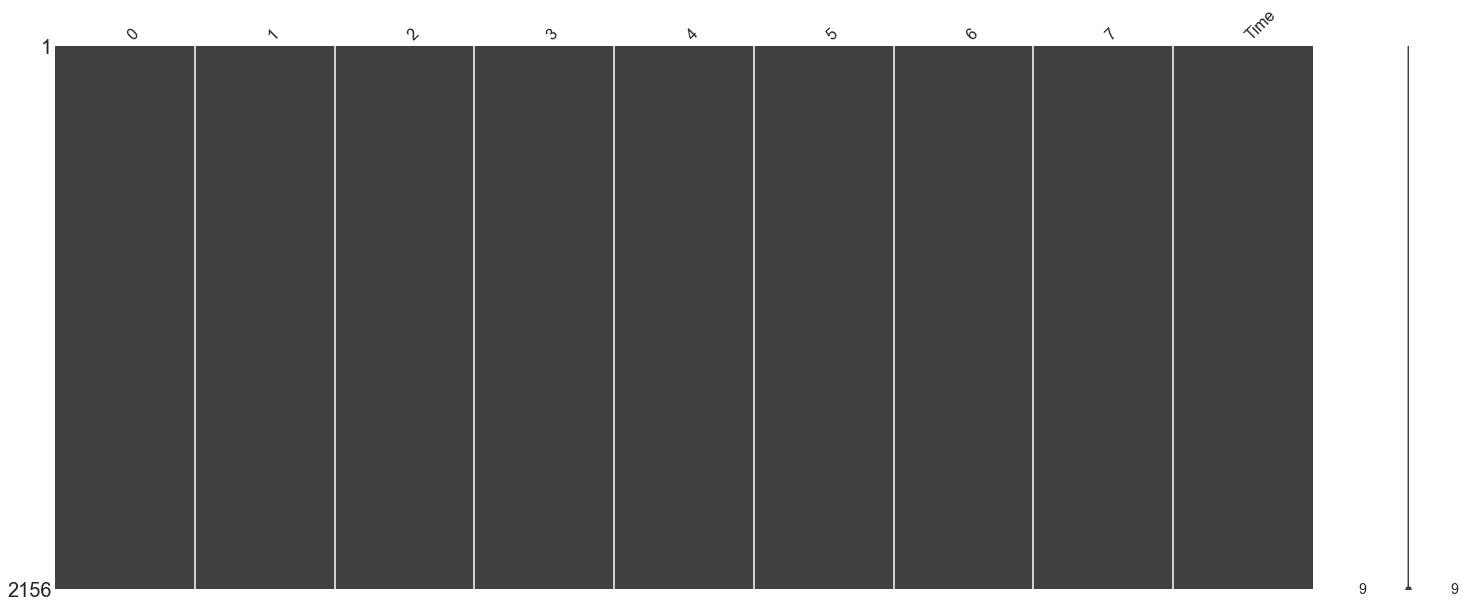

In [6]:
# check missing values
msno.matrix(data)

[Text(0.5,0,'Time (min)')]

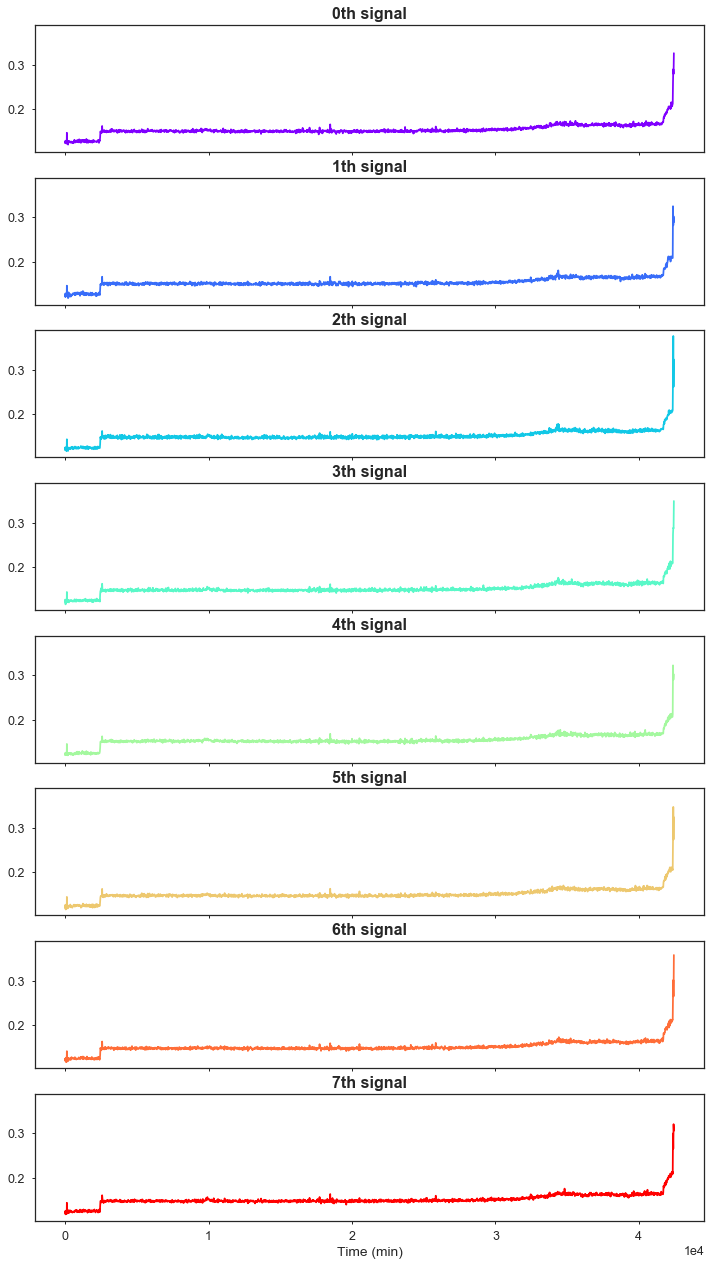

In [7]:
# draw plot of each signals
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(8, sharex=True, sharey=True, figsize=(12,22))
colors = cm.rainbow(np.linspace(0, 1, 8))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # use fancy indexing to plot data in each state
    mask = data.Time == i
    ax.plot(data.Time,
            data[i],
            c=color)
    ax.set_title("{0}th signal".format(i), fontsize=16, fontweight='demi')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set(xlabel='Time (min)')

In [8]:
from pomegranate import *

In [9]:
features = [0, 1, 2, 3, 4, 5, 6, 7]
X_seqs = data[features].values
X_seqs.shape

(2156, 8)

In [10]:
print(X_seqs[:, 7]) # get data from indices

[0.12252021 0.12285546 0.12333331 ... 0.26557859 0.32097499 0.30624523]


# Using from_matrix

In [11]:
transmat = np.array([[0.6, 0.2, 0.2], [0.5, 0.3, 0.2], [0.3, 0.2, 0.5]]) # transition matrix
start_probs = np.array([0.5, 0.2, 0.3]) # initial states
states = [NormalDistribution(0,1), NormalDistribution(0,1), NormalDistribution(0,1)]

In [12]:
from_matrix_models = []

for i in range(X_seqs.shape[1]):
    model = HiddenMarkovModel.from_matrix(transmat, states, start_probs, merge='None')
    model.fit([X_seqs[:, i]], verbose=True, algorithm='baum-welch')
    logp = model.log_probability([X_seqs[:,i]])
    from_matrix_models.append([model, logp])

[1] Improvement: 8395.251854192713	Time (s): 0.003992
[2] Improvement: 0.09167039816475153	Time (s): 0.003987
[3] Improvement: 26.68619143658998	Time (s): 0.005985
[4] Improvement: 342.3981240360781	Time (s): 0.002992
[5] Improvement: 519.2237598905203	Time (s): 0.002991
[6] Improvement: 407.31026547054444	Time (s): 0.002992
[7] Improvement: 672.9631837255811	Time (s): 0.003989
[8] Improvement: 176.72116838060538	Time (s): 0.002992
[9] Improvement: 20.527096478101157	Time (s): 0.002992
[10] Improvement: 1.5817404050631012	Time (s): 0.002992
[11] Improvement: 1.5206200158227148	Time (s): 0.002992
[12] Improvement: 2.852727095450973	Time (s): 0.002992
[13] Improvement: 4.557753398776185	Time (s): 0.002992
[14] Improvement: 5.9883866135623975	Time (s): 0.002992
[15] Improvement: 6.7888414908375125	Time (s): 0.002992
[16] Improvement: 7.003986704530689	Time (s): 0.002992
[17] Improvement: 6.823953662182248	Time (s): 0.003989
[18] Improvement: 6.493292751063564	Time (s): 0.002991
[19] Impro

[13] Improvement: 0.00011054975948354695	Time (s): 0.002992
[14] Improvement: 3.590400956454687e-05	Time (s): 0.002991
[15] Improvement: 1.165895264421124e-05	Time (s): 0.002992
[16] Improvement: 3.7859172152820975e-06	Time (s): 0.002992
[17] Improvement: 1.2293712643440813e-06	Time (s): 0.002992
[18] Improvement: 3.991208359366283e-07	Time (s): 0.002992
[19] Improvement: 1.296793925575912e-07	Time (s): 0.002995
[20] Improvement: 4.2316969484090805e-08	Time (s): 0.002991
[21] Improvement: 1.3405951904132962e-08	Time (s): 0.002991
[22] Improvement: 4.549292498268187e-09	Time (s): 0.002992
[23] Improvement: 8.567440090700984e-10	Time (s): 0.002991
Total Training Improvement: 2021.310591835815
Total Training Time (s): 0.0738
[1] Improvement: 2200.2787478221817	Time (s): 0.002993
[2] Improvement: 509.2674809533146	Time (s): 0.004
[3] Improvement: 105.53834153820935	Time (s): 0.00298
[4] Improvement: 26.08730130879485	Time (s): 0.002992
[5] Improvement: 19.764344438082844	Time (s): 0.002992

In [13]:
i = 1
for m in from_matrix_models:
    model, logp = m[0], m[1]
    print("Pi", i)
    print(model.dense_transition_matrix()[model.start_index, :model.silent_start])
    print("Transition matrix", i)
    print(model.dense_transition_matrix()[:model.silent_start, :model.silent_start])
    print("logp", i)
    print(logp)
    print()
    i += 1

Pi 1
[0. 0. 1.]
Transition matrix 1
[[9.66888928e-01 2.88921086e-02 4.21896328e-03]
 [5.92591753e-03 9.94074082e-01 7.52219467e-45]
 [3.15050799e-62 1.68731552e-03 9.98312684e-01]]
logp 1
1.777520748068255

Pi 2
[0. 0. 1.]
Transition matrix 2
[[9.95138265e-001 6.51666604e-013 4.86173532e-003]
 [7.39750501e-004 9.97972808e-001 1.28744142e-003]
 [2.03864779e-104 4.60204620e-003 9.95397954e-001]]
logp 2
1.7160772640409963

Pi 3
[0. 0. 1.]
Transition matrix 3
[[9.95490413e-01 2.10102043e-13 4.50958715e-03]
 [6.63554562e-04 9.99336445e-01 2.85866143e-25]
 [5.11287703e-03 5.01108065e-03 9.89876042e-01]]
logp 3
2.2623683520174045

Pi 4
[0. 0. 1.]
Transition matrix 4
[[9.97755578e-01 9.67780399e-40 2.24442167e-03]
 [7.00505910e-13 9.98126012e-01 1.87398837e-03]
 [4.23971793e-03 1.14835819e-02 9.84276700e-01]]
logp 4
2.3094655397416726

Pi 5
[0. 0. 1.]
Transition matrix 5
[[9.94696414e-01 3.38435964e-03 1.91922648e-03]
 [1.91830087e-03 9.98081699e-01 1.54139992e-19]
 [2.51315986e-47 5.20426390e

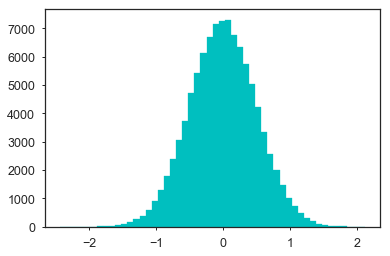

In [14]:
d = NormalDistribution(0, 0.5)
d.plot( n=100000, edgecolor='c', color='c', bins=50 )

# Using from_sample

In [15]:
X = [X_seqs]

In [16]:
from_sample_model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, n_components=3, X=X, algorithm='baum-welch')

In [17]:
print("Pi")
print(from_sample_model.dense_transition_matrix()[from_sample_model.start_index, :from_sample_model.silent_start])
print("\nTransition matrix")
print(from_sample_model.dense_transition_matrix()[:from_sample_model.silent_start, :from_sample_model.silent_start])
print("\nlogp")
print(from_sample_model.log_probability(X))

Pi
[4.10320421e-202 1.00000000e+000 3.48232326e-120]

Transition matrix
[[9.89732900e-01 3.23242395e-89 1.02671003e-02]
 [4.54690220e-52 8.88881936e-01 1.11118064e-01]
 [2.66600557e-01 2.01141962e-01 5.32257481e-01]]

logp
38.459741021290846


In [18]:
XX = [X_seqs[:, 0]]

In [19]:
from_samples_models = []

for i in range(X_seqs.shape[1]):
    model = HiddenMarkovModel.from_samples(MultivariateGaussianDistribution, n_components=3, X=[X_seqs[:, i]], verbose=True)
    logp = model.log_probability([X_seqs[:,i]])
    from_samples_models.append([model, logp])

[1] Improvement: 2092.5200821900053	Time (s): 0.006982
[2] Improvement: 1440.3092564967237	Time (s): 0.006982
[3] Improvement: 49.62376717610823	Time (s): 0.007979
[4] Improvement: 2.196570002968656	Time (s): 0.006981
[5] Improvement: 3.563049751368453	Time (s): 0.006981
[6] Improvement: 2.278439702009564	Time (s): 0.006982
[7] Improvement: 0.39614025798800867	Time (s): 0.006981
[8] Improvement: 0.040559294113336364	Time (s): 0.007021
[9] Improvement: 0.0031071706434886437	Time (s): 0.006979
[10] Improvement: 0.0002235202155134175	Time (s): 0.006979
[11] Improvement: 1.5984822312020697e-05	Time (s): 0.006983
[12] Improvement: 1.1523134162416682e-06	Time (s): 0.00698
[13] Improvement: 8.423376129940152e-08	Time (s): 0.00698
[14] Improvement: 6.024492904543877e-09	Time (s): 0.006947
[15] Improvement: 5.820766091346741e-10	Time (s): 0.007978
Total Training Improvement: 3590.9312127901203
Total Training Time (s): 0.1197
[1] Improvement: 2124.9675737104053	Time (s): 0.006943
[2] Improvement

In [20]:
i = 1
for model in from_samples_models:
    model, logp = model[0], model[1]
    print("Pi", i)
    print(model.dense_transition_matrix()[model.start_index, :model.silent_start])
    print("Transition matrix", i)
    print(model.dense_transition_matrix()[:model.silent_start, :model.silent_start])
    print("logp", i)
    print(logp)
    print()
    i += 1

Pi 1
[0. 1. 0.]
Transition matrix 1
[[9.97274445e-01 8.59356479e-15 2.72555524e-03]
 [5.18867874e-03 9.94811321e-01 2.47305402e-24]
 [5.98383617e-03 2.00852873e-03 9.92007635e-01]]
logp 1
2.301162224357813

Pi 2
[0. 1. 0.]
Transition matrix 2
[[9.97928895e-01 1.24753054e-14 2.07110511e-03]
 [5.19972279e-03 9.94800277e-01 2.84436068e-23]
 [3.94562526e-03 1.96454678e-03 9.94089828e-01]]
logp 2
2.256662584854282

Pi 3
[0. 1. 0.]
Transition matrix 3
[[9.99336445e-01 3.62197407e-19 6.63554562e-04]
 [5.01108065e-03 9.89876042e-01 5.11287703e-03]
 [1.12787167e-13 4.50958716e-03 9.95490413e-01]]
logp 3
2.2623683519810482

Pi 4
[0.000000e+000 1.000000e+000 3.925277e-318]
Transition matrix 4
[[9.97844741e-01 1.33678506e-14 2.15525893e-03]
 [5.19804003e-03 9.94801960e-01 8.15304521e-26]
 [4.35623315e-03 2.01816597e-03 9.93625601e-01]]
logp 4
2.2864894879116195

Pi 5
[0. 1. 0.]
Transition matrix 5
[[9.97586169e-01 2.40095828e-17 2.41383116e-03]
 [5.21141556e-03 9.94788584e-01 3.95792349e-34]
 [5.1

In [21]:
i = 0
llogp = []
lmodel = []
for model in from_samples_models:
    model, logp = model[0], model[1]
    lmodel.append('model '+str(i))
    llogp.append(logp)
    i += 1

In [22]:
d = {'model': lmodel, 'logp': llogp}
df_logp = pd.DataFrame(d)

In [23]:
df_logp

,model,logp
0,model 0,2.301162
1,model 1,2.256663
2,model 2,2.262368
3,model 3,2.286489
4,model 4,2.252333
5,model 5,2.234037
6,model 6,2.258962
7,model 7,2.301374


# Using bake

In [24]:
d = MultivariateGaussianDistribution(np.arange(2) * 2, np.eye(2))
print (d.sample())

[1.76405235 2.40015721]


In [25]:
# s1 = State(GeneralMixtureModel([NormalDistribution(0, 0.5), UniformDistribution(0, 0.5)]))
# s2 = State(GeneralMixtureModel([NormalDistribution(0, 0.5), UniformDistribution(0, 0.5)]))
# s3 = State(GeneralMixtureModel([NormalDistribution(0, 0.5), UniformDistribution(0, 0.5)]))

s1 = State(MultivariateGaussianDistribution(np.arange(2) * 2, np.eye(2)), name='state 1')
s2 = State(MultivariateGaussianDistribution(np.arange(2) * 2, np.eye(2)), name='state 2')
s3 = State(MultivariateGaussianDistribution(np.arange(2) * 2, np.eye(2)), name='state 3')

bake_model = HiddenMarkovModel()
bake_model.add_states([s1, s2, s3])
bake_model.add_transition(model.start, s1, 0.33)
bake_model.add_transition(model.start, s2, 0.33)
bake_model.add_transition(model.start, s3, 0.34)

bake_model.add_transition(s1, s1, 0.33)
bake_model.add_transition(s1, s2, 0.33)
bake_model.add_transition(s1, s3, 0.34)

bake_model.add_transition(s2, s1, 0.33)
bake_model.add_transition(s2, s2, 0.33)
bake_model.add_transition(s2, s3, 0.34)

bake_model.add_transition(s3, s1, 0.33)
bake_model.add_transition(s3, s2, 0.33)
bake_model.add_transition(s3, s3, 0.34)

bake_model.bake()
# print(bake_model)

In [26]:
X = [X_seqs]
# print(X_seqs.shape)
bake_model.fit(X, algorithm='baum-welch')
print("Pi")
print(bake_model.dense_transition_matrix()[bake_model.start_index, :bake_model.silent_start])
print("\nTransition matrix")
print(bake_model.dense_transition_matrix()[:bake_model.silent_start, :bake_model.silent_start])
print(bake_model.viterbi(X_seqs[:, 0]))

Pi
[0. 0. 0.]

Transition matrix
[[0.33 0.33 0.34]
 [0.33 0.33 0.34]
 [0.33 0.33 0.34]]
(-inf, None)


# Test

In [27]:
data_test = pd.read_csv('Data/data_rms_bearing_2.txt', header = None, sep='\s+')
data_test.head()

,0,1,2,3
0,0.085298,0.084981,0.084102,0.084256
1,0.086073,0.086420,0.086052,0.085643
2,0.087299,0.086021,0.084995,0.087011
3,0.086777,0.087066,0.086819,0.087537
4,0.086714,0.086268,0.088115,0.085511


# Details dataset test
- Recording Duration:  February 12, 2004 10:32:39 to February 19, 2004 06:22:39 
- No. of Files: 984 
- No. of Channels:  4 
- Channel Arrangement:  Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4. 
- File Recording Interval:  Every 10 minutes 
- File Format:  ASCII 
- Description: At the end of the test-to-failure experiment, outer race failure occurred in bearing 1. 

In [28]:
# create list minutes
minutes = []
start = 0
for t in range(len(data_test)):
    # Every 10 minutes
    minutes.append(start)
    start += 10

In [29]:
# add into dataframe
se = pd.Series(minutes)
data_test['Time'] = se.values
data_test.head()

,0,1,2,3,Time
0,0.085298,0.084981,0.084102,0.084256,0
1,0.086073,0.086420,0.086052,0.085643,10
2,0.087299,0.086021,0.084995,0.087011,20
3,0.086777,0.087066,0.086819,0.087537,30
4,0.086714,0.086268,0.088115,0.085511,40


[Text(0.5,0,'Time (min)')]

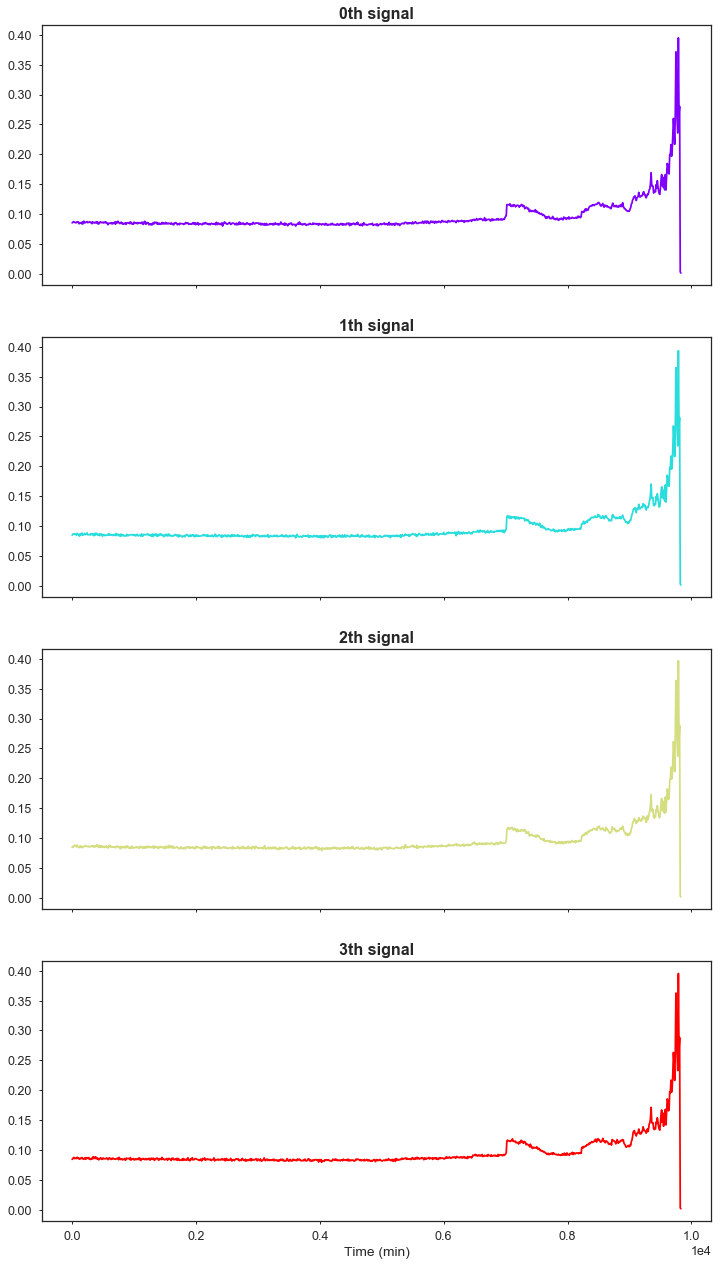

In [30]:
# draw plot of each signals
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(4, sharex=True, sharey=True, figsize=(12,22))
colors = cm.rainbow(np.linspace(0, 1, 4))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # use fancy indexing to plot data in each state
    mask = data_test.Time == i
    ax.plot(data_test.Time,
            data_test[i],
            c=color)
    ax.set_title("{0}th signal".format(i), fontsize=16, fontweight='demi')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set(xlabel='Time (min)')

In [31]:
bearing_test3 = data_test[2]
bearing_test3.head()

0    0.084102
1    0.086052
2    0.084995
3    0.086819
4    0.088115
Name: 2, dtype: float64

In [32]:
best_model, best_logp = from_samples_models[7]
# print(best_logp)
# best_model
print((best_model.predict(bearing_test3.values)))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# Test on specific data bearing 4 channel 2

In [33]:
data.head()

,0,1,2,3,4,5,6,7,Time
0,0.124086,0.123077,0.124692,0.123098,0.121993,0.120885,0.120650,0.122520,0
1,0.125157,0.121047,0.119458,0.121360,0.123017,0.120512,0.123048,0.122855,5
2,0.125133,0.125864,0.122109,0.126549,0.124533,0.121847,0.120396,0.123333,10
3,0.125903,0.122256,0.125582,0.123162,0.122565,0.122018,0.124485,0.125027,15
4,0.123719,0.128365,0.121615,0.123504,0.119830,0.126062,0.123403,0.122291,20


In [34]:
data42 = data[7]
data42.describe()

count    2156.000000
mean        0.150312
std         0.012780
min         0.117361
25%         0.146482
50%         0.148342
75%         0.153606
max         0.320975
Name: 7, dtype: float64

In [46]:
data42.tail()

2151    0.208512
2152    0.300020
2153    0.265579
2154    0.320975
2155    0.306245
Name: 7, dtype: float64

In [35]:
from sklearn.cluster import KMeans

In [36]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data42.values.reshape(-1, 1))

In [37]:
d = {'data': data42.tolist(), 'labels': kmeans.labels_.tolist()}

In [38]:
result = pd.DataFrame(data=d)
result.head()

,data,labels
0,0.122520,2
1,0.122855,2
2,0.123333,2
3,0.125027,2
4,0.122291,2


In [39]:
cluster0 = []
cluster1 = []
cluster2 = []
for index, row in result.iterrows():
    if row['labels'] == 2:
        cluster0.append(row['data'])
#         print(row['data'])
    elif row['labels'] == 0:
        cluster1.append(row['data'])
#         print(row['data'])
    elif row['labels'] == 1:
        cluster2.append(row['data'])
#         print(row['data'])

In [40]:
print(len(cluster0), len(cluster1), len(cluster2))

155 1966 35


In [47]:
data42 = X_seqs[:, 7]

In [50]:
print((best_model.predict(data42)))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 